In [1]:
# Визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Базовые библиотеки
import pathlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Базовый ввод данных
DATA_DIR = pathlib.Path("./data")  # Откуда считываем данные
RS = 42
train = pd.read_parquet(DATA_DIR.joinpath("train.parquet"))
CAT = ["feature4"]
TARGETS = ["target0", "target1"]  # список таргетов для модели
FTS = train.filter(like="feature").columns.difference(CAT)  # Выбираем фичи для модели
train["gas"] = 0
train.loc[train.feature4=="gas2", "gas"] = 1
FTS = FTS.union(["gas"])  # список фичей для модели

X_tr, X_val, y_tr, y_val = train_test_split(train[FTS], train[TARGETS], train_size=0.5, random_state=RS)  # разбивка на трейн и тест

## Балансировка

In [16]:
y_int_10p4 = y_tr.copy()
for tg in TARGETS:
    y_int_10p4[tg] = y_tr[tg].apply(lambda x: int(x*10000))

In [5]:
# y_int_10p4

In [6]:
# y_int_10p4.nunique()

In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE  # попробуем такой позже
from imblearn.over_sampling import SMOTE

In [8]:
TARGETS

['target0', 'target1']

In [20]:
%%time
X_smpl, y_smpl = {}, {}
for tg in TARGETS:
    print(f"{tg}", "=" * 10)
    oversampler = RandomOverSampler(random_state=RS)
    
    oversampler.fit(X_tr, y_int_10p4[tg])  
    xs, ys = oversampler.fit_resample(X_tr, y_int_10p4[tg])  

    X_smpl[tg] = xs
    y_smpl[tg] = ys/10000

target0 ==========
target1 ==========
CPU times: total: 1min 25s
Wall time: 1min 26s


In [ ]:
# %%time
# sampled_data = {}
# for tg in TARGETS:
#     print(f"{tg}", "=" * 10)
#     oversampler = RandomOverSampler(random_state=RS)
    
#     oversampler.fit(X_tr.values, y_int_10p6[tg].values)  
#     X_smpl, y_ampl = oversampler.fit_resample(X_tr.values, y_int_10p6[tg].values)  

#     sampled_data[tg] = data

## Моделирование

In [11]:
# Базовая

# models = {}
# tr_preds = []
# val_preds = []

# for tg in TARGETS:
#     print(f"{tg}", "=" * 10)
#     cb_model = CatBoostRegressor(max_depth=4, iterations=5000,
#                                  early_stopping_rounds=20, objective="MAPE", verbose=200,
#                                  random_state=RS)
#     cb_model.fit(X_tr, y_tr[tg], eval_set=(X_val, y_val[tg]))

#     tr_preds.append(cb_model.predict(X_tr))
#     val_preds.append(cb_model.predict(X_val))

#     models[tg] = cb_model

In [12]:
from sklearn.neural_network import MLPRegressor

In [13]:
mlp = MLPRegressor(hidden_layer_sizes=(26, 1024, 512, 256), random_state=RS)

In [21]:
%%time
models = {}
tr_preds = []
val_preds = []

for tg in TARGETS:
    print(f"{tg}", "=" * 10)
    mlp = MLPRegressor(hidden_layer_sizes=(25, 1024, 512, 256), random_state=RS)
    
    mlp.fit(X_smpl[tg], y_smpl[tg])  # не забудь убрать

    tr_preds.append(mlp.predict(X_smpl[tg]))

    val_preds.append(mlp.predict(X_val))

    models[tg] = mlp

target0 ==========
target1 ==========


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: total: 5d 9h 5min 35s
Wall time: 21h 40min 32s


In [24]:
val_preds

[array([78.88495592, 73.84796163, 86.63257023, ..., 24.53125355,
        20.6909039 , 28.33943899]),
 array([43.74347647, 37.130981  , 52.28467295, ...,  7.45540397,
         1.80897168,  3.65883783])]

In [23]:
tr_preds

[array([31.80757309, 74.24620044, 82.99219363, ..., 95.14411809,
        95.14411809, 95.14411809]),
 array([ 6.58296966, 32.93160511, 51.74047055, ..., 81.7105613 ,
        81.7105613 , 81.7105613 ])]

Собираем предсказания вместе:

In [25]:
tr_preds = np.column_stack(tr_preds)
val_preds = np.column_stack(val_preds)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 346760 and the array at index 1 has size 385872

In [ ]:
tr_preds = np.clip(tr_preds, 0, 100)
val_preds = np.clip(val_preds, 0, 100)

Посчитаем метрики (так они считаются и для загрузок на платформе):

In [28]:
print(f"MAPE (train): {mean_absolute_percentage_error(y_tr, tr_preds) * 100:.3f} %")
print(f"MAPE (val): {mean_absolute_percentage_error(y_val, val_preds) * 100:.3f} %")

ValueError: Found input variables with inconsistent numbers of samples: [76708, 2]

Сохраним модели:

In [ ]:
for target, model in models.items():
    model.save_model(DATA_DIR.joinpath(f"{target}-cb-v1.cbm"))

In [26]:
import pickle

In [27]:
for target, model in models.items():
    with open(DATA_DIR.joinpath(f"{target}-cb-v1.mlp"), 'wb') as f:
        pickle.dump(model, f)

In [33]:
X_smpl[tg]

0          6.5919
1         32.8697
2         52.2396
3          1.8447
4          4.9219
           ...   
385867    81.8407
385868    81.8407
385869    81.8407
385870    81.8407
385871    81.8407
Name: target1, Length: 385872, dtype: float64

In [32]:
for tg in TARGETS:
    
    X_smpl[tg].to_excel(f'x_data_{tg}.xlsx')
    y_smpl[tg].to_excel(f'y_data_{tg}.xlsx')

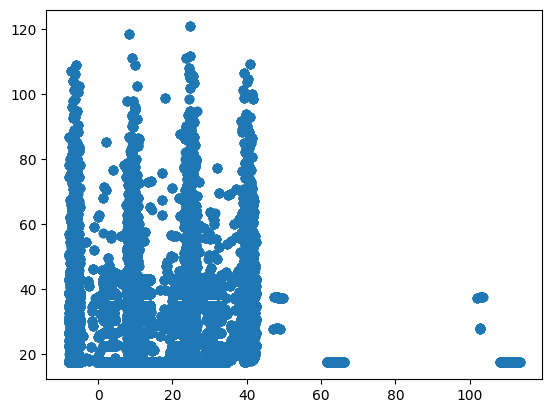

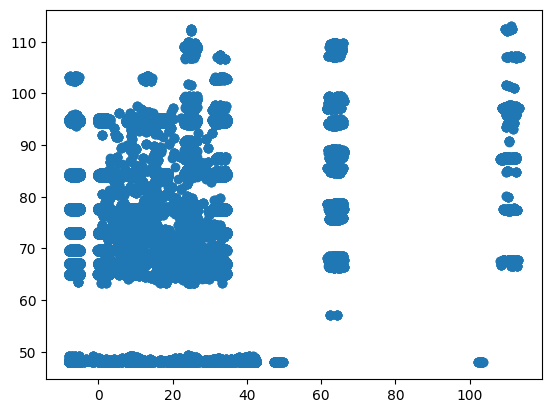

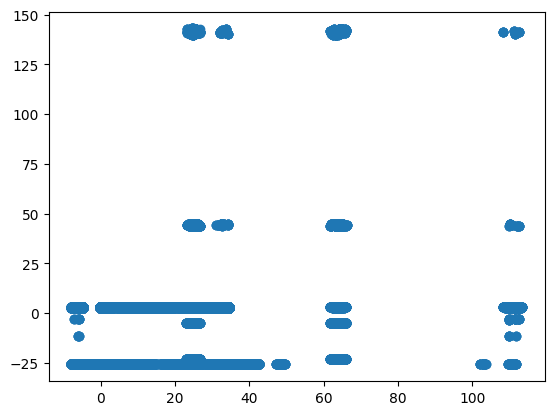

ValueError: x and y must be the same size

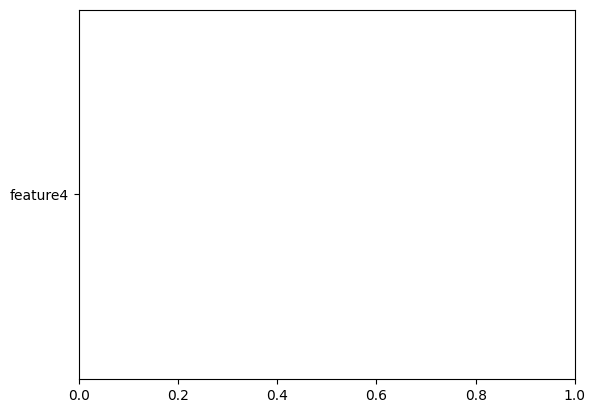

In [35]:
plt.scatter(x='feature0', y='feature1', data=X_smpl[tg])
plt.show()

plt.scatter(x='feature0', y='feature2', data=X_smpl[tg])
plt.show()

plt.scatter(x='feature0', y='feature3', data=X_smpl[tg])
plt.show()

plt.scatter(x='feature0', y='feature4', data=X_smpl[tg])
plt.show()

plt.scatter(x='feature0', y='feature5', data=X_smpl[tg])
plt.show()